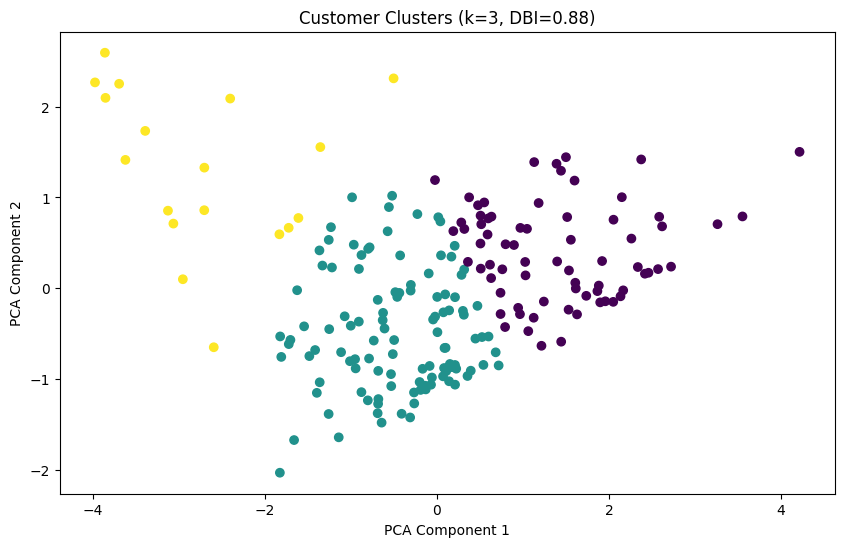


Cluster Statistics:
            Recency  Frequency     Monetary
Cluster                                    
0         55.070423   7.253521  5333.158592
1         59.981818   4.090909  2619.645182
2        244.166667   1.944444  1287.796111

Davies-Bouldin Index: 0.880153375840541


In [8]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load and merge data
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')
merged = pd.merge(transactions, customers, on='CustomerID')

# Convert to datetime first
merged['TransactionDate'] = pd.to_datetime(merged['TransactionDate'])

# Create RFM features
snapshot_date = merged['TransactionDate'].max() + pd.DateOffset(days=1)
rfm = merged.groupby('CustomerID').agg(
    Recency=('TransactionDate', lambda x: (snapshot_date - x.max()).days),
    Frequency=('TransactionID', 'count'),
    Monetary=('TotalValue', 'sum')
).reset_index()

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Find optimal clusters using DBI
best_db = float('inf')
best_k = 2

for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    db_score = davies_bouldin_score(scaled_features, labels)
    
    if db_score < best_db:
        best_db = db_score
        best_k = k

# Final clustering
kmeans = KMeans(n_clusters=best_k, n_init=50, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(scaled_features)

# Visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 6))
plt.scatter(pca_features[:,0], pca_features[:,1], c=rfm['Cluster'], cmap='viridis')
plt.title(f'Customer Clusters (k={best_k}, DBI={best_db:.2f})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Cluster analysis
print("\nCluster Statistics:")
print(rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean())
print("\nDavies-Bouldin Index:", best_db)